# Лабораторная работа №5 по курсу "Технологии машинного обучения"
## Выполнила Попова Дарья, студентка группы РТ5-61Б

## Ансамбли моделей машинного обучения. Задача бинарной классификации.

Продолжим исследовать датасет для классификации из ЛР №4.

Датасет состоит из 77 колонок с уровнями выделения различных белков у мышей, которые разделены на 2 группы: контрольную и трисомическую.

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('C:\\Users\\Дасупс\\Downloads\\Data_Cortex_Nuclear.csv')

## Предобработка данных

Я удалю столбцы Genotype, Treatment и Behavior и сделаю целевой признак бинарным. Задача, таким образом, будет сводиться к задаче бинарной классификации и будет состоять в предсказании наличия у мыши трисомии (1 - есть, 0 - нет) на основании 77 колонок с показателями выделения белков корой головного мозга.

In [4]:
df['class'] = df['class'].replace(['c-CS-m', 'c-SC-m', 'c-CS-s', 'c-SC-s'], 0)
df['class'] = df['class'].replace(['t-CS-m', 't-SC-m', 't-CS-s', 't-SC-s'], 1)

Разделим данные на независимые фичи и целевой признак. Для столбцов-предсказателей к тому же удалим столбец с ID каждой мыши, а также столбцы Genotype, Treatment и Behavior.

In [5]:
X = df.drop(['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class'], axis=1)
y = df['class']

In [6]:
# убедимся, что в целевой функции у нас нет пропусков
df['class'].isnull().any()

False

In [7]:
# сначала убедимся, что все 77 фичей являются числовыми
num = 0
for column in X.columns:
    if X[column].dtype == 'float64' or X[column].dtype == 'int':
        num += 1
num

77

Обработаем пропуски.

In [8]:
from sklearn.impute import SimpleImputer

# заполним пропуски во всех колонках
for column in X.columns:
    null_count = X[column].isnull().sum()
    if null_count > 0:
        imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        X[column] = imputer.fit_transform(X[[column]])
        
# убедимся, что пропусков не осталось
null_sum = 0
for column in X.columns:
    null_count = X[column].isnull().sum()
    null_sum += null_count
null_sum

0

Убедимся в том, что масштабирование можно не применять.

<AxesSubplot:ylabel='Density'>

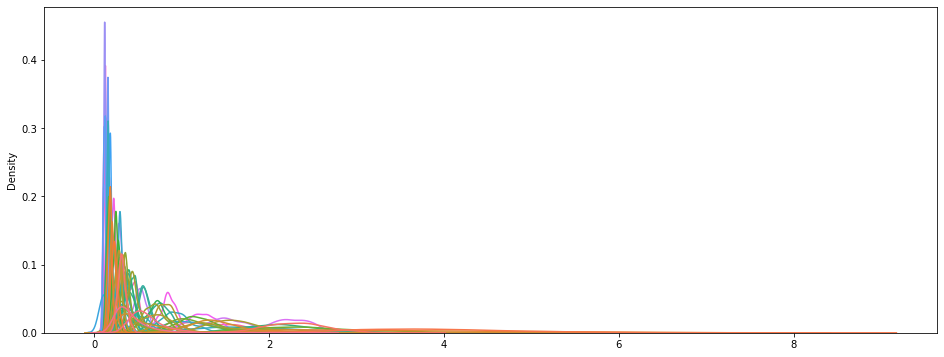

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
sns.kdeplot(data=X, legend=False)

## Разделение датасета на обучающую и тестовую выборку

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Построение и обучение ансамблей 

## Случайный лес

In [11]:
from sklearn.ensemble import RandomForestClassifier

Сначала обучим случайный лес на произвольных значениях гиперпараметров.

In [12]:
rand_forest = RandomForestClassifier(n_estimators=5, max_features=4, n_jobs=-1, random_state=42)

In [14]:
rand_forest.fit(X_train, y_train)
rand_forest_predicted = rand_forest.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(y_true, y_predicted):
    print("{:<15} {:<15}".format('метрика','значение'))
    print()
    print("{:<15} {:<15}".format('accuracy', round(accuracy_score(y_true, y_predicted),4)))
    print("{:<15} {:<15}".format('precision', round(precision_score(y_true, y_predicted),4)))
    print("{:<15} {:<15}".format('recall', round(recall_score(y_true, y_predicted),4)))
    print("{:<15} {:<15}".format('f1_score', round(f1_score(y_true, y_predicted),4)))

In [17]:
print_metrics(y_test, rand_forest_predicted)

метрика         значение       

accuracy        0.9444         
precision       0.9322         
recall          0.9402         
f1_score        0.9362         


Даже на случайно подобранных гиперпараметрах случайный лес показывает более хороший результат, чем простое решающее дерево из прошлой лабы!

Теперь попробуем найти оптимальные гиперпараметры с помощью решётчатого поиска.

In [40]:
params = {'n_estimators':range(1,25,2), 'max_features':range(1,30,2), 'max_depth':range(1,7)}

In [41]:
%%time
forest_grid = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)
forest_grid.fit(X_train, y_train)

Wall time: 1min 43s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 7),
                         'max_features': range(1, 30, 2),
                         'n_estimators': range(1, 25, 2)})

In [42]:
forest_grid.best_params_

{'max_depth': 6, 'max_features': 17, 'n_estimators': 21}

In [43]:
best_forest_predicted = forest_grid.best_estimator_.predict(X_test)
print_metrics(y_test, best_forest_predicted)

метрика         значение       

accuracy        0.9815         
precision       0.9912         
recall          0.9658         
f1_score        0.9784         


In [39]:
from sklearn.ensemble import GradientBoostingClassifier
grad_boost = GradientBoostingClassifier(random_state=42)
grad_boost.fit(X_train, y_train)
boost_predicted = grad_boost.predict(X_test)

print_metrics(y_test, boost_predicted)

метрика         значение       

accuracy        0.9778         
precision       0.9664         
recall          0.9829         
f1_score        0.9746         
